# Load Necessaries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from model.classifier import *

# Train

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from utils.utils import MelSpectrogramDataset


train_data_dir = "/home/crois-times/timeseries/JJ/Harvard_Multimodal/Mel_spectrogram/T1"  # T1: Train + Val

batch_size = 32
num_epochs = 10
learning_rate = 0.001
image_size = (128, 128)
train_anomaly_threshold = 4041  # T1에서 4041 이후 Anomaly
test_anomaly_threshold = 4961  # T5에서 4961 이후 Anomaly


transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # ← RGB 3채널이면 3개 지정
                         std=[0.5, 0.5, 0.5])
])

# === 데이터 로더 준비 ===
train_dataset_full = MelSpectrogramDataset(
    data_dir=train_data_dir,
    train_anomaly_threshold=train_anomaly_threshold,
    transform=transform
)

# Train/Validation Split (80% Train, 20% Val)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset_full, [train_size, val_size]
)



In [5]:


batch_size = 32
num_epochs = 10
learning_rate = 0.001
image_size = (128, 128)
train_anomaly_threshold = 4041  # T1에서 4041 이후 Anomaly
test_anomaly_threshold = 4961  # T5에서 4961 이후 Anomaly


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cnn = CNNClassifier().to(device)
eff = EfficientNetBinary(pretrained=True).to(device)
mob = MobileNetBinary(pretrained=True).to(device)
res = ResNetClassifier(pretrained=True).to(device)
vit = ViTBinary(pretrained=True).to(device)
deit = DeiTBinary(pretrained=True).to(device)
swin = SwinBinary(pretrained=True).to(device)
beit = BEiTBinary(pretrained=True).to(device)



/home/crois-times/anaconda3/lib/python3.11/site-packages/timm/layers/interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  idx_right = torch.bucketize(x, p)


In [38]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # tqdm 추가


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,          # CPU 코어 절반 이상
    pin_memory=True,       # GPU 전송 최적화
    persistent_workers=True # worker 재사용 (epoch마다 fork 방지)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)


def evaluate_model(model, val_loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels, _ in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(val_loader), correct / total  # 평균 Loss, Accuracy 반환


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    best_val_loss = float("inf")  # 초기화 (최적 모델 저장용)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

        for images, labels, _ in progress_bar:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(correct/total):.4f}")

        # Epoch 종료 후 검증 수행
        train_loss = running_loss / len(train_loader)
        val_loss, val_acc = evaluate_model(model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # 최적 모델 저장 (Validation Loss 기준)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Model Saved (Best Val Loss: {best_val_loss:.4f})")

        print(f"\nEpoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc :{(correct/total):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Loss Curve 그리기
    plot_loss_curve(train_losses, val_losses)

# === Loss Curve 시각화 함수 ===
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(val_losses, label="Val Loss", marker="o", linestyle="dashed")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train & Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.savefig("loss_curve.png")  # Loss Curve 저장
    plt.show()



### Vanilla CNN

In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

Epoch [1/10]: 100%|██████████| 162/162 [00:15<00:00, 10.59it/s, acc=0.6889, loss=0.4928]


Model Saved (Best Val Loss: 0.5153)

Epoch [1/10] - Train Loss: 0.5717, Train Acc :0.6889, Val Loss: 0.5153, Val Acc: 0.7438


Epoch [2/10]: 100%|██████████| 162/162 [00:12<00:00, 12.74it/s, acc=0.8032, loss=0.3340]


Model Saved (Best Val Loss: 0.2804)

Epoch [2/10] - Train Loss: 0.4125, Train Acc :0.8032, Val Loss: 0.2804, Val Acc: 0.8511


Epoch [3/10]: 100%|██████████| 162/162 [00:13<00:00, 11.70it/s, acc=0.9147, loss=0.4317]


Model Saved (Best Val Loss: 0.1722)

Epoch [3/10] - Train Loss: 0.1996, Train Acc :0.9147, Val Loss: 0.1722, Val Acc: 0.9252


Epoch [4/10]: 100%|██████████| 162/162 [00:12<00:00, 12.49it/s, acc=0.9396, loss=0.0677]


Model Saved (Best Val Loss: 0.1121)

Epoch [4/10] - Train Loss: 0.1405, Train Acc :0.9396, Val Loss: 0.1121, Val Acc: 0.9552


Epoch [5/10]: 100%|██████████| 162/162 [00:15<00:00, 10.13it/s, acc=0.9630, loss=0.0831]



Epoch [5/10] - Train Loss: 0.0923, Train Acc :0.9630, Val Loss: 0.1165, Val Acc: 0.9429


Epoch [6/10]: 100%|██████████| 162/162 [00:15<00:00, 10.48it/s, acc=0.9759, loss=0.0257]


Model Saved (Best Val Loss: 0.0485)

Epoch [6/10] - Train Loss: 0.0613, Train Acc :0.9759, Val Loss: 0.0485, Val Acc: 0.9838


Epoch [7/10]: 100%|██████████| 162/162 [00:15<00:00, 10.28it/s, acc=0.9894, loss=0.0155]


Model Saved (Best Val Loss: 0.0406)

Epoch [7/10] - Train Loss: 0.0354, Train Acc :0.9894, Val Loss: 0.0406, Val Acc: 0.9846


Epoch [8/10]: 100%|██████████| 162/162 [00:14<00:00, 11.37it/s, acc=0.9909, loss=0.0109]


Model Saved (Best Val Loss: 0.0292)

Epoch [8/10] - Train Loss: 0.0270, Train Acc :0.9909, Val Loss: 0.0292, Val Acc: 0.9869


Epoch [9/10]: 100%|██████████| 162/162 [00:16<00:00, 10.10it/s, acc=0.9954, loss=0.0179]



Epoch [9/10] - Train Loss: 0.0169, Train Acc :0.9954, Val Loss: 0.0316, Val Acc: 0.9861


Epoch [10/10]: 100%|██████████| 162/162 [00:17<00:00,  9.40it/s, acc=0.9981, loss=0.0128]



Epoch [10/10] - Train Loss: 0.0088, Train Acc :0.9981, Val Loss: 0.0455, Val Acc: 0.9830


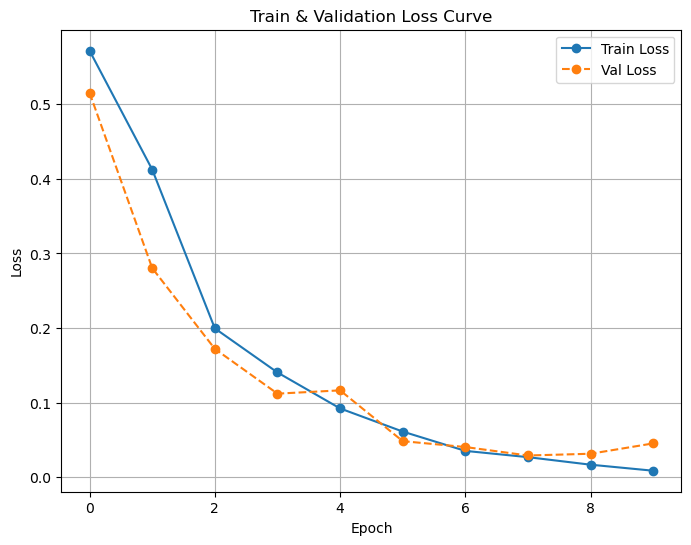

In [17]:
learning_rate = 0.001
image_size = (128, 128)
train_anomaly_threshold = 4041  # T1에서 4041 이후 Anomaly

train_model(cnn, train_loader, val_loader, criterion, optimizer, num_epochs)

In [18]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_cnn.pth"

# 모델 저장
torch.save(cnn.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_cnn.pth


### ResNet

Epoch [1/10]: 100%|██████████| 162/162 [00:13<00:00, 11.97it/s, acc=0.9111, loss=0.0295]


Model Saved (Best Val Loss: 0.5906)

Epoch [1/10] - Train Loss: 0.2028, Train Acc :0.9111, Val Loss: 0.5906, Val Acc: 0.7577


Epoch [2/10]: 100%|██████████| 162/162 [00:15<00:00, 10.17it/s, acc=0.9882, loss=0.0015]


Model Saved (Best Val Loss: 0.0096)

Epoch [2/10] - Train Loss: 0.0348, Train Acc :0.9882, Val Loss: 0.0096, Val Acc: 0.9985


Epoch [3/10]: 100%|██████████| 162/162 [00:16<00:00,  9.67it/s, acc=0.9967, loss=0.0001]


Model Saved (Best Val Loss: 0.0005)

Epoch [3/10] - Train Loss: 0.0115, Train Acc :0.9967, Val Loss: 0.0005, Val Acc: 1.0000


Epoch [4/10]: 100%|██████████| 162/162 [00:19<00:00,  8.45it/s, acc=0.9973, loss=0.0011]



Epoch [4/10] - Train Loss: 0.0085, Train Acc :0.9973, Val Loss: 0.0006, Val Acc: 1.0000


Epoch [5/10]: 100%|██████████| 162/162 [00:15<00:00, 10.56it/s, acc=0.9983, loss=0.0002]



Epoch [5/10] - Train Loss: 0.0051, Train Acc :0.9983, Val Loss: 0.2017, Val Acc: 0.9198


Epoch [6/10]: 100%|██████████| 162/162 [00:17<00:00,  9.15it/s, acc=1.0000, loss=0.0000]


Model Saved (Best Val Loss: 0.0002)

Epoch [6/10] - Train Loss: 0.0007, Train Acc :1.0000, Val Loss: 0.0002, Val Acc: 1.0000


Epoch [7/10]: 100%|██████████| 162/162 [00:15<00:00, 10.61it/s, acc=0.9904, loss=0.0039]



Epoch [7/10] - Train Loss: 0.0322, Train Acc :0.9904, Val Loss: 1.3968, Val Acc: 0.6420


Epoch [8/10]: 100%|██████████| 162/162 [00:13<00:00, 11.77it/s, acc=0.9965, loss=0.0005]



Epoch [8/10] - Train Loss: 0.0108, Train Acc :0.9965, Val Loss: 0.0040, Val Acc: 0.9985


Epoch [9/10]: 100%|██████████| 162/162 [00:12<00:00, 12.94it/s, acc=1.0000, loss=0.0001]


Model Saved (Best Val Loss: 0.0001)

Epoch [9/10] - Train Loss: 0.0004, Train Acc :1.0000, Val Loss: 0.0001, Val Acc: 1.0000


Epoch [10/10]: 100%|██████████| 162/162 [00:14<00:00, 11.07it/s, acc=1.0000, loss=0.0000]


Model Saved (Best Val Loss: 0.0001)

Epoch [10/10] - Train Loss: 0.0002, Train Acc :1.0000, Val Loss: 0.0001, Val Acc: 1.0000


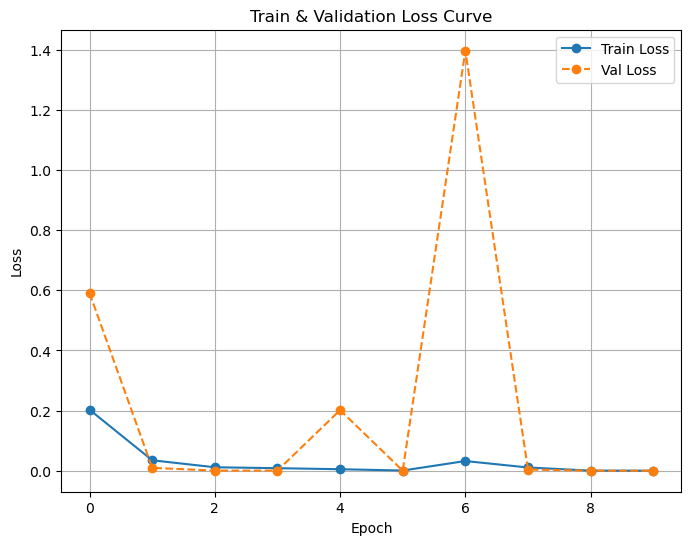

In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(res.parameters(), lr=learning_rate)
train_model(res, train_loader, val_loader, criterion, optimizer, num_epochs)

In [20]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_res.pth"

# 모델 저장
torch.save(res.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_res.pth


### EfficientNet

Epoch [1/10]: 100%|██████████| 162/162 [00:16<00:00,  9.89it/s, acc=0.8524, loss=0.1375]


Model Saved (Best Val Loss: 0.0949)

Epoch [1/10] - Train Loss: 2.6411, Train Acc :0.8524, Val Loss: 0.0949, Val Acc: 0.9637


Epoch [2/10]: 100%|██████████| 162/162 [00:16<00:00,  9.98it/s, acc=0.9755, loss=0.0433]



Epoch [2/10] - Train Loss: 0.0676, Train Acc :0.9755, Val Loss: 0.2406, Val Acc: 0.9144


Epoch [3/10]: 100%|██████████| 162/162 [00:16<00:00,  9.67it/s, acc=0.9956, loss=0.0002]


Model Saved (Best Val Loss: 0.0029)

Epoch [3/10] - Train Loss: 0.0178, Train Acc :0.9956, Val Loss: 0.0029, Val Acc: 0.9985


Epoch [4/10]: 100%|██████████| 162/162 [00:18<00:00,  8.76it/s, acc=0.9973, loss=0.0316]



Epoch [4/10] - Train Loss: 0.0095, Train Acc :0.9973, Val Loss: 0.0464, Val Acc: 0.9830


Epoch [5/10]: 100%|██████████| 162/162 [00:14<00:00, 11.25it/s, acc=0.9963, loss=0.0001]



Epoch [5/10] - Train Loss: 0.0113, Train Acc :0.9963, Val Loss: 0.0252, Val Acc: 0.9931


Epoch [6/10]: 100%|██████████| 162/162 [00:14<00:00, 11.14it/s, acc=0.9961, loss=0.0009]



Epoch [6/10] - Train Loss: 0.0123, Train Acc :0.9961, Val Loss: 0.1044, Val Acc: 0.9660


Epoch [7/10]: 100%|██████████| 162/162 [00:15<00:00, 10.46it/s, acc=0.9994, loss=0.0000]


Model Saved (Best Val Loss: 0.0002)

Epoch [7/10] - Train Loss: 0.0040, Train Acc :0.9994, Val Loss: 0.0002, Val Acc: 1.0000


Epoch [8/10]: 100%|██████████| 162/162 [00:17<00:00,  9.16it/s, acc=1.0000, loss=0.0000]



Epoch [8/10] - Train Loss: 0.0002, Train Acc :1.0000, Val Loss: 0.0052, Val Acc: 0.9985


Epoch [9/10]: 100%|██████████| 162/162 [00:17<00:00,  9.36it/s, acc=1.0000, loss=0.0000]



Epoch [9/10] - Train Loss: 0.0004, Train Acc :1.0000, Val Loss: 0.0110, Val Acc: 0.9985


Epoch [10/10]: 100%|██████████| 162/162 [00:17<00:00,  9.17it/s, acc=1.0000, loss=0.0000]



Epoch [10/10] - Train Loss: 0.0001, Train Acc :1.0000, Val Loss: 0.0053, Val Acc: 0.9985


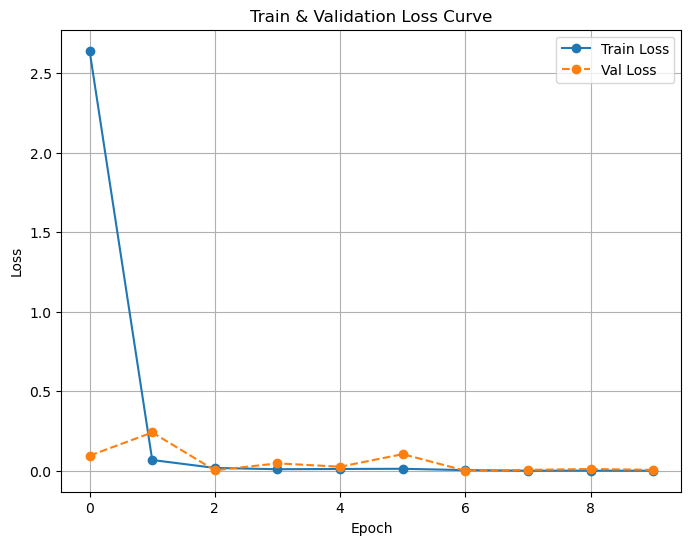

In [40]:
criterion = nn.BCELoss()
optimizer = optim.Adam(eff.parameters(), lr=learning_rate)
train_model(eff, train_loader, val_loader, criterion, optimizer, num_epochs)

In [41]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_eff.pth"

# 모델 저장
torch.save(eff.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_eff.pth


### mobilenet

Epoch [1/10]: 100%|██████████| 162/162 [00:14<00:00, 11.12it/s, acc=0.9238, loss=0.0097]


Model Saved (Best Val Loss: 0.1053)

Epoch [1/10] - Train Loss: 0.1769, Train Acc :0.9238, Val Loss: 0.1053, Val Acc: 0.9660


Epoch [2/10]: 100%|██████████| 162/162 [00:14<00:00, 11.21it/s, acc=0.9923, loss=0.0231]


Model Saved (Best Val Loss: 0.0120)

Epoch [2/10] - Train Loss: 0.0259, Train Acc :0.9923, Val Loss: 0.0120, Val Acc: 0.9969


Epoch [3/10]: 100%|██████████| 162/162 [00:14<00:00, 11.15it/s, acc=0.9904, loss=0.0019]



Epoch [3/10] - Train Loss: 0.0290, Train Acc :0.9904, Val Loss: 0.0211, Val Acc: 0.9954


Epoch [4/10]: 100%|██████████| 162/162 [00:17<00:00,  9.35it/s, acc=0.9977, loss=0.0027]


Model Saved (Best Val Loss: 0.0098)

Epoch [4/10] - Train Loss: 0.0088, Train Acc :0.9977, Val Loss: 0.0098, Val Acc: 0.9977


Epoch [5/10]: 100%|██████████| 162/162 [00:14<00:00, 10.86it/s, acc=0.9994, loss=0.0001]


Model Saved (Best Val Loss: 0.0006)

Epoch [5/10] - Train Loss: 0.0017, Train Acc :0.9994, Val Loss: 0.0006, Val Acc: 1.0000


Epoch [6/10]: 100%|██████████| 162/162 [00:16<00:00,  9.92it/s, acc=0.9992, loss=0.0006]



Epoch [6/10] - Train Loss: 0.0023, Train Acc :0.9992, Val Loss: 0.2363, Val Acc: 0.9313


Epoch [7/10]: 100%|██████████| 162/162 [00:13<00:00, 12.19it/s, acc=0.9971, loss=0.0001]


Model Saved (Best Val Loss: 0.0002)

Epoch [7/10] - Train Loss: 0.0092, Train Acc :0.9971, Val Loss: 0.0002, Val Acc: 1.0000


Epoch [8/10]: 100%|██████████| 162/162 [00:15<00:00, 10.72it/s, acc=0.9985, loss=0.0000]


Model Saved (Best Val Loss: 0.0001)

Epoch [8/10] - Train Loss: 0.0054, Train Acc :0.9985, Val Loss: 0.0001, Val Acc: 1.0000


Epoch [9/10]: 100%|██████████| 162/162 [00:15<00:00, 10.69it/s, acc=1.0000, loss=0.0000]


Model Saved (Best Val Loss: 0.0000)

Epoch [9/10] - Train Loss: 0.0002, Train Acc :1.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch [10/10]: 100%|██████████| 162/162 [00:13<00:00, 12.45it/s, acc=1.0000, loss=0.0000]


Model Saved (Best Val Loss: 0.0000)

Epoch [10/10] - Train Loss: 0.0001, Train Acc :1.0000, Val Loss: 0.0000, Val Acc: 1.0000


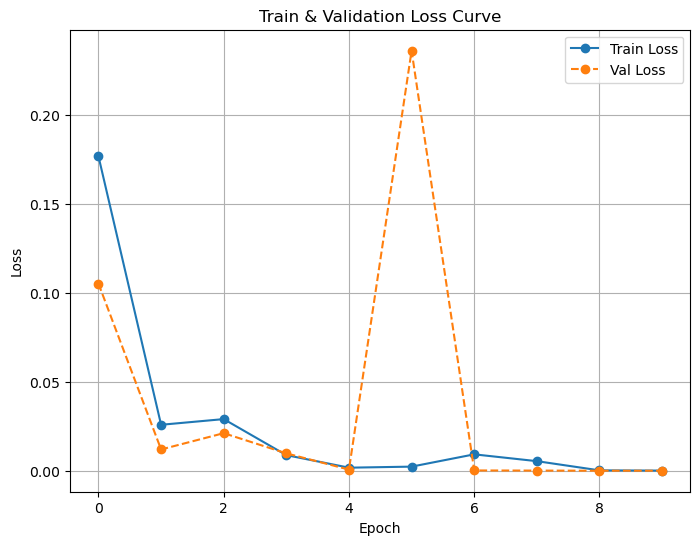

In [21]:
criterion = nn.BCELoss()
optimizer = optim.Adam(mob.parameters(), lr=learning_rate)
train_model(mob, train_loader, val_loader, criterion, optimizer, num_epochs)

In [22]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_mob.pth"

# 모델 저장
torch.save(mob.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_mob.pth


### Vision Transformer

Epoch [1/10]: 100%|██████████| 162/162 [00:15<00:00, 10.66it/s, acc=0.5999, loss=0.8426]


Model Saved (Best Val Loss: 0.7002)

Epoch [1/10] - Train Loss: 0.7671, Train Acc :0.5999, Val Loss: 0.7002, Val Acc: 0.6227


Epoch [2/10]: 100%|██████████| 162/162 [00:15<00:00, 10.20it/s, acc=0.6441, loss=0.6146]


Model Saved (Best Val Loss: 0.6050)

Epoch [2/10] - Train Loss: 0.6353, Train Acc :0.6441, Val Loss: 0.6050, Val Acc: 0.6937


Epoch [3/10]: 100%|██████████| 162/162 [00:14<00:00, 11.05it/s, acc=0.6842, loss=0.7318]


Model Saved (Best Val Loss: 0.5844)

Epoch [3/10] - Train Loss: 0.5943, Train Acc :0.6842, Val Loss: 0.5844, Val Acc: 0.6991


Epoch [4/10]: 100%|██████████| 162/162 [00:13<00:00, 11.65it/s, acc=0.6919, loss=0.4448]



Epoch [4/10] - Train Loss: 0.5770, Train Acc :0.6919, Val Loss: 0.6160, Val Acc: 0.6821


Epoch [5/10]: 100%|██████████| 162/162 [00:18<00:00,  8.66it/s, acc=0.7006, loss=0.5355]


Model Saved (Best Val Loss: 0.5563)

Epoch [5/10] - Train Loss: 0.5645, Train Acc :0.7006, Val Loss: 0.5563, Val Acc: 0.7022


Epoch [6/10]: 100%|██████████| 162/162 [00:15<00:00, 10.45it/s, acc=0.7184, loss=0.4156]


Model Saved (Best Val Loss: 0.4595)

Epoch [6/10] - Train Loss: 0.5372, Train Acc :0.7184, Val Loss: 0.4595, Val Acc: 0.7801


Epoch [7/10]: 100%|██████████| 162/162 [00:14<00:00, 11.04it/s, acc=0.7585, loss=0.4602]



Epoch [7/10] - Train Loss: 0.4747, Train Acc :0.7585, Val Loss: 0.4654, Val Acc: 0.7785


Epoch [8/10]: 100%|██████████| 162/162 [00:16<00:00,  9.64it/s, acc=0.7583, loss=0.5666]



Epoch [8/10] - Train Loss: 0.4724, Train Acc :0.7583, Val Loss: 0.4898, Val Acc: 0.7523


Epoch [9/10]: 100%|██████████| 162/162 [00:16<00:00,  9.86it/s, acc=0.7556, loss=0.3359]


Model Saved (Best Val Loss: 0.4222)

Epoch [9/10] - Train Loss: 0.4621, Train Acc :0.7556, Val Loss: 0.4222, Val Acc: 0.7840


Epoch [10/10]: 100%|██████████| 162/162 [00:15<00:00, 10.63it/s, acc=0.7766, loss=0.4247]


Model Saved (Best Val Loss: 0.3764)

Epoch [10/10] - Train Loss: 0.4339, Train Acc :0.7766, Val Loss: 0.3764, Val Acc: 0.8187


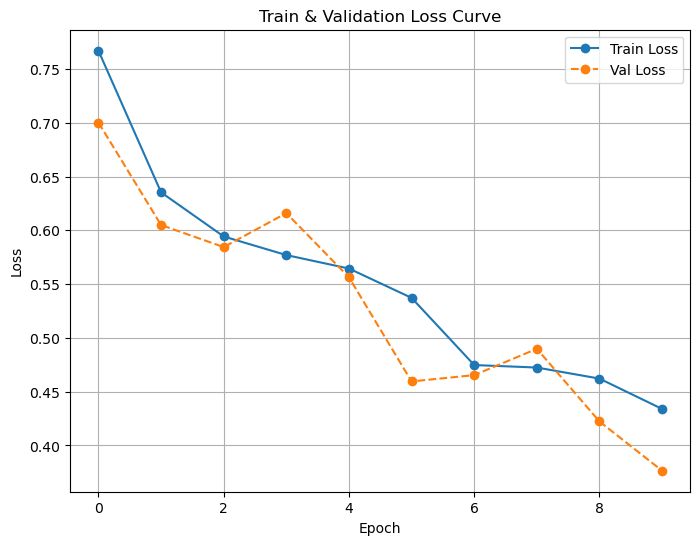

In [23]:
criterion = nn.BCELoss()
optimizer = optim.Adam(vit.parameters(), lr=learning_rate)
train_model(vit, train_loader, val_loader, criterion, optimizer, num_epochs)

In [24]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_vit.pth"

# 모델 저장
torch.save(vit.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_vit.pth


### DeiT

Epoch [1/10]: 100%|██████████| 162/162 [00:17<00:00,  9.46it/s, acc=0.6175, loss=0.6425]


Model Saved (Best Val Loss: 0.6515)

Epoch [1/10] - Train Loss: 0.6798, Train Acc :0.6175, Val Loss: 0.6515, Val Acc: 0.6034


Epoch [2/10]: 100%|██████████| 162/162 [00:15<00:00, 10.29it/s, acc=0.6730, loss=0.3856]


Model Saved (Best Val Loss: 0.5391)

Epoch [2/10] - Train Loss: 0.5905, Train Acc :0.6730, Val Loss: 0.5391, Val Acc: 0.7083


Epoch [3/10]: 100%|██████████| 162/162 [00:15<00:00, 10.40it/s, acc=0.7556, loss=0.4213]


Model Saved (Best Val Loss: 0.4958)

Epoch [3/10] - Train Loss: 0.4624, Train Acc :0.7556, Val Loss: 0.4958, Val Acc: 0.7176


Epoch [4/10]: 100%|██████████| 162/162 [00:14<00:00, 11.12it/s, acc=0.8029, loss=0.2567]


Model Saved (Best Val Loss: 0.4901)

Epoch [4/10] - Train Loss: 0.4071, Train Acc :0.8029, Val Loss: 0.4901, Val Acc: 0.7569


Epoch [5/10]: 100%|██████████| 162/162 [00:18<00:00,  8.59it/s, acc=0.8405, loss=0.2335]


Model Saved (Best Val Loss: 0.3576)

Epoch [5/10] - Train Loss: 0.3606, Train Acc :0.8405, Val Loss: 0.3576, Val Acc: 0.8465


Epoch [6/10]: 100%|██████████| 162/162 [00:16<00:00,  9.85it/s, acc=0.8395, loss=0.3924]


Model Saved (Best Val Loss: 0.3236)

Epoch [6/10] - Train Loss: 0.3445, Train Acc :0.8395, Val Loss: 0.3236, Val Acc: 0.8650


Epoch [7/10]: 100%|██████████| 162/162 [00:16<00:00,  9.85it/s, acc=0.8596, loss=0.3073]


Model Saved (Best Val Loss: 0.3015)

Epoch [7/10] - Train Loss: 0.3099, Train Acc :0.8596, Val Loss: 0.3015, Val Acc: 0.8727


Epoch [8/10]: 100%|██████████| 162/162 [00:15<00:00, 10.51it/s, acc=0.8709, loss=0.2355]


Model Saved (Best Val Loss: 0.2724)

Epoch [8/10] - Train Loss: 0.2916, Train Acc :0.8709, Val Loss: 0.2724, Val Acc: 0.8758


Epoch [9/10]: 100%|██████████| 162/162 [00:15<00:00, 10.67it/s, acc=0.8598, loss=0.1824]


Model Saved (Best Val Loss: 0.2629)

Epoch [9/10] - Train Loss: 0.3114, Train Acc :0.8598, Val Loss: 0.2629, Val Acc: 0.8843


Epoch [10/10]: 100%|██████████| 162/162 [00:15<00:00, 10.14it/s, acc=0.8787, loss=0.2608]



Epoch [10/10] - Train Loss: 0.2750, Train Acc :0.8787, Val Loss: 0.2729, Val Acc: 0.8696


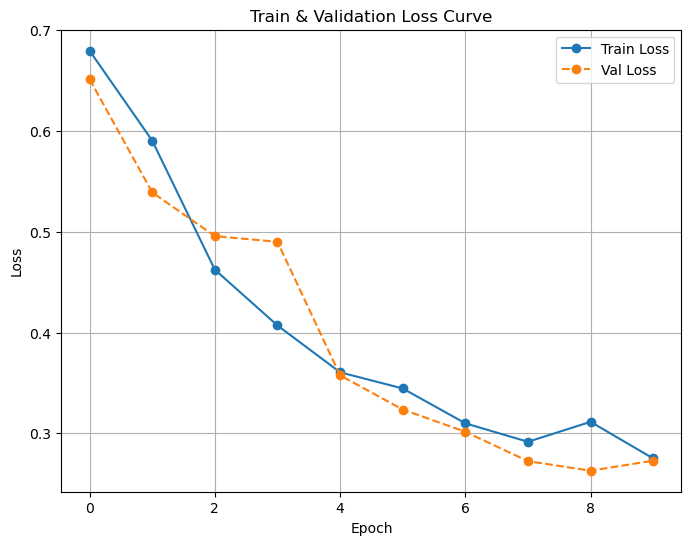

In [25]:
criterion = nn.BCELoss()
optimizer = optim.Adam(deit.parameters(), lr=learning_rate)
train_model(deit, train_loader, val_loader, criterion, optimizer, num_epochs)

In [26]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_deit.pth"

# 모델 저장
torch.save(deit.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_deit.pth


### Swin Transformer

Epoch [1/10]: 100%|██████████| 162/162 [00:28<00:00,  5.64it/s, acc=0.5926, loss=0.7000]


Model Saved (Best Val Loss: 0.6938)

Epoch [1/10] - Train Loss: 0.6994, Train Acc :0.5926, Val Loss: 0.6938, Val Acc: 0.3850


Epoch [2/10]: 100%|██████████| 162/162 [00:27<00:00,  5.91it/s, acc=0.6076, loss=0.6724]


Model Saved (Best Val Loss: 0.6657)

Epoch [2/10] - Train Loss: 0.6801, Train Acc :0.6076, Val Loss: 0.6657, Val Acc: 0.6150


Epoch [3/10]: 100%|██████████| 162/162 [00:27<00:00,  5.79it/s, acc=0.6192, loss=0.5632]



Epoch [3/10] - Train Loss: 0.6700, Train Acc :0.6192, Val Loss: 0.6672, Val Acc: 0.6150


Epoch [4/10]: 100%|██████████| 162/162 [00:25<00:00,  6.47it/s, acc=0.6229, loss=0.6317]



Epoch [4/10] - Train Loss: 0.6698, Train Acc :0.6229, Val Loss: 0.6659, Val Acc: 0.6150


Epoch [5/10]: 100%|██████████| 162/162 [00:26<00:00,  6.17it/s, acc=0.6258, loss=0.7697]



Epoch [5/10] - Train Loss: 0.6660, Train Acc :0.6258, Val Loss: 0.6756, Val Acc: 0.6150


Epoch [6/10]: 100%|██████████| 162/162 [00:21<00:00,  7.38it/s, acc=0.6256, loss=0.6573]



Epoch [6/10] - Train Loss: 0.6642, Train Acc :0.6256, Val Loss: 0.6698, Val Acc: 0.6150


Epoch [7/10]: 100%|██████████| 162/162 [00:27<00:00,  5.95it/s, acc=0.6258, loss=0.6657]



Epoch [7/10] - Train Loss: 0.6637, Train Acc :0.6258, Val Loss: 0.6675, Val Acc: 0.6150


Epoch [8/10]: 100%|██████████| 162/162 [00:24<00:00,  6.50it/s, acc=0.6258, loss=0.6312]



Epoch [8/10] - Train Loss: 0.6644, Train Acc :0.6258, Val Loss: 0.6659, Val Acc: 0.6150


Epoch [9/10]: 100%|██████████| 162/162 [00:26<00:00,  6.05it/s, acc=0.6256, loss=0.7205]



Epoch [9/10] - Train Loss: 0.6636, Train Acc :0.6256, Val Loss: 0.6657, Val Acc: 0.6150


Epoch [10/10]: 100%|██████████| 162/162 [00:23<00:00,  7.02it/s, acc=0.6258, loss=0.6174]



Epoch [10/10] - Train Loss: 0.6622, Train Acc :0.6258, Val Loss: 0.6659, Val Acc: 0.6150


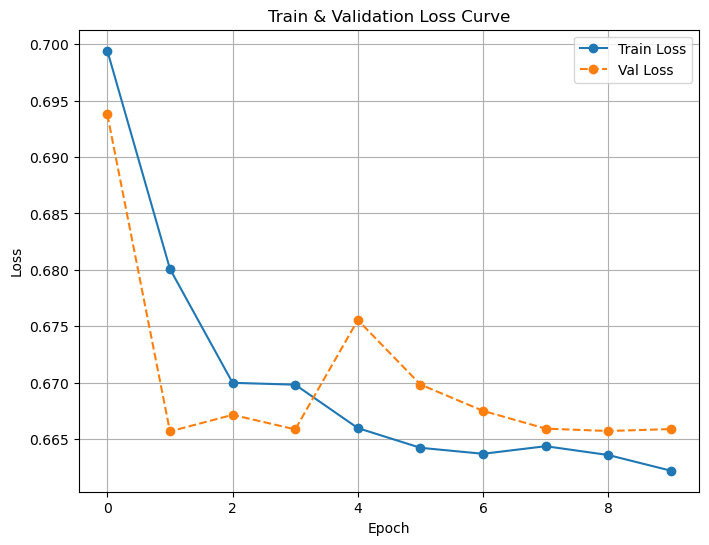

In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(swin.parameters(), lr=learning_rate)
train_model(swin, train_loader, val_loader, criterion, optimizer, num_epochs)

In [8]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_swin.pth"

# 모델 저장
torch.save(swin.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_swin.pth


### BeiT

Epoch [1/10]: 100%|██████████| 162/162 [00:17<00:00,  9.24it/s, acc=0.6256, loss=0.6075]


Model Saved (Best Val Loss: 0.6487)

Epoch [1/10] - Train Loss: 0.6559, Train Acc :0.6256, Val Loss: 0.6487, Val Acc: 0.6150


Epoch [2/10]: 100%|██████████| 162/162 [00:20<00:00,  7.97it/s, acc=0.6460, loss=0.5446]


Model Saved (Best Val Loss: 0.5948)

Epoch [2/10] - Train Loss: 0.6266, Train Acc :0.6460, Val Loss: 0.5948, Val Acc: 0.6798


Epoch [3/10]: 100%|██████████| 162/162 [00:15<00:00, 10.32it/s, acc=0.6925, loss=0.7480]


Model Saved (Best Val Loss: 0.5597)

Epoch [3/10] - Train Loss: 0.5790, Train Acc :0.6925, Val Loss: 0.5597, Val Acc: 0.7199


Epoch [4/10]: 100%|██████████| 162/162 [00:16<00:00,  9.71it/s, acc=0.7006, loss=0.4466]


Model Saved (Best Val Loss: 0.5576)

Epoch [4/10] - Train Loss: 0.5689, Train Acc :0.7006, Val Loss: 0.5576, Val Acc: 0.7060


Epoch [5/10]: 100%|██████████| 162/162 [00:15<00:00, 10.40it/s, acc=0.7035, loss=0.5404]


Model Saved (Best Val Loss: 0.5410)

Epoch [5/10] - Train Loss: 0.5585, Train Acc :0.7035, Val Loss: 0.5410, Val Acc: 0.7400


Epoch [6/10]: 100%|██████████| 162/162 [00:17<00:00,  9.24it/s, acc=0.6813, loss=0.6259]



Epoch [6/10] - Train Loss: 0.5859, Train Acc :0.6813, Val Loss: 0.5888, Val Acc: 0.7006


Epoch [7/10]: 100%|██████████| 162/162 [00:17<00:00,  9.41it/s, acc=0.7002, loss=0.5649]



Epoch [7/10] - Train Loss: 0.5727, Train Acc :0.7002, Val Loss: 0.5990, Val Acc: 0.6759


Epoch [8/10]: 100%|██████████| 162/162 [00:17<00:00,  9.38it/s, acc=0.7047, loss=0.4498]



Epoch [8/10] - Train Loss: 0.5645, Train Acc :0.7047, Val Loss: 0.6156, Val Acc: 0.6520


Epoch [9/10]: 100%|██████████| 162/162 [00:16<00:00,  9.84it/s, acc=0.6939, loss=0.5268]



Epoch [9/10] - Train Loss: 0.5740, Train Acc :0.6939, Val Loss: 0.6350, Val Acc: 0.6319


Epoch [10/10]: 100%|██████████| 162/162 [00:15<00:00, 10.39it/s, acc=0.6908, loss=0.5073]



Epoch [10/10] - Train Loss: 0.5734, Train Acc :0.6908, Val Loss: 0.5738, Val Acc: 0.7006


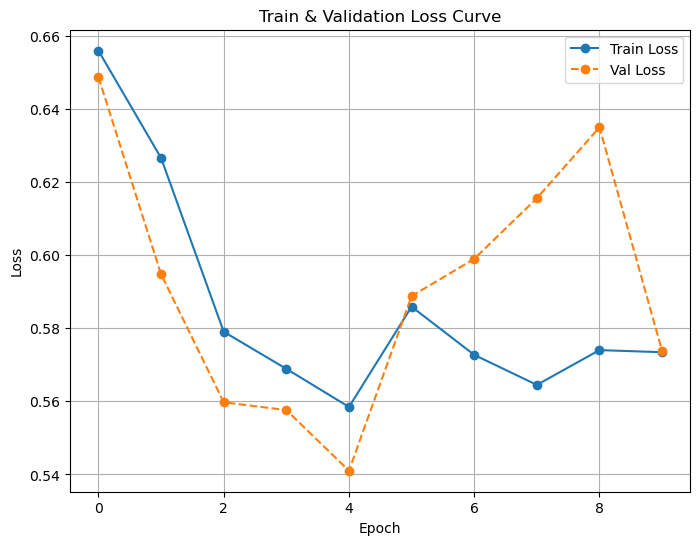

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(beit.parameters(), lr=learning_rate)
train_model(beit, train_loader, val_loader, criterion, optimizer, num_epochs)

In [10]:
# 저장할 경로
save_path = "./model_weights/classifier_T1_beit.pth"

# 모델 저장
torch.save(beit.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1_beit.pth


# Classifier Inference

In [7]:

test_data_dir = "/home/crois-times/timeseries/JJ/Harvard_Multimodal/Mel_spectrogram/T5"  # T5: Test
test_anomaly_threshold = 4961  

test_dataset = MelSpectrogramDataset(
    data_dir=test_data_dir,
    train_anomaly_threshold=test_anomaly_threshold,
    transform=transform
)

In [8]:
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,          # CPU 코어 절반 이상
    pin_memory=True,       # GPU 전송 최적화
    persistent_workers=True # worker 재사용 (epoch마다 fork 방지)
)

In [17]:
# def evaluate_test(model, test_loader):
#     model.eval()
#     correct, total = 0, 0
#     predictions = []

#     with torch.no_grad():
#         for images, labels, _ in test_loader:
#             images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
#             outputs = model(images)
#             predicted = (outputs > 0.5).float()
#             probabilities = outputs.sigmoid().cpu().numpy().flatten()  # 예측 확률값 추가

#             #  Accuracy 계산
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)

#             # 라벨을 squeeze()로 차원 맞춰서 저장
#             for true_label, pred_prob in zip(labels.cpu().numpy().squeeze(), probabilities):
#                 predictions.append((int(true_label), pred_prob))  # 예측 확률 포함

#     accuracy = correct / total
#     print(f"Test Accuracy: {accuracy:.4f}")
#     return predictions  # 예측 결과 반환

In [6]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import numpy as np
import torch

def evaluate_test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    predictions = []

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)

            predicted = (outputs > 0.5).float()
            probabilities = outputs.cpu().numpy().flatten() 

    
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            labels_np = labels.cpu().numpy().squeeze()
            for true_label, pred_prob in zip(labels_np, probabilities):
                predictions.append((int(true_label), pred_prob))

            all_labels.extend(labels_np.tolist())
            all_probs.extend(probabilities.tolist())

    accuracy = correct / total if total > 0 else 0.0

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    binary_preds = (all_probs > 0.5).astype(int)

    precision = precision_score(all_labels, binary_preds, zero_division=0)
    recall = recall_score(all_labels, binary_preds, zero_division=0)
    f1 = f1_score(all_labels, binary_preds, zero_division=0)

    try:
        auc_roc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc_roc = float("nan")

    try:
        auc_pr = average_precision_score(all_labels, all_probs)
    except ValueError:
        auc_pr = float("nan")

    # === 출력 ===
    print(f"Test Accuracy : {accuracy:.4f}")
    print(f"Precision     : {precision:.4f}")
    print(f"Recall        : {recall:.4f}")
    print(f"F1-score      : {f1:.4f}")
    print(f"AUROC         : {auc_roc:.4f}")
    print(f"AUPRC         : {auc_pr:.4f}")

    return predictions  # 기존처럼 예측 결과 반환


### Vanilla CNN

In [9]:

model = CNNClassifier().to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_cnn.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()



CNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
test_predictions = evaluate_test(model, test_loader)

Test Accuracy : 0.8670
Precision     : 0.6384
Recall        : 0.9974
F1-score      : 0.7785
AUROC         : 0.9883
AUPRC         : 0.9612


### EfficientNet

In [11]:
eff = EfficientNetBinary(pretrained=False).to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_eff.pth"
eff.load_state_dict(torch.load(checkpoint_path, map_location=device))
eff.eval()

EfficientNetBinary(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw

In [12]:
test_predictions = evaluate_test(eff, test_loader)

Test Accuracy : 0.8583
Precision     : 0.6233
Recall        : 1.0000
F1-score      : 0.7679
AUROC         : 0.9103
AUPRC         : 0.6305


### MobileNet

In [13]:
mob = MobileNetBinary(pretrained=False).to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_mob.pth"
mob.load_state_dict(torch.load(checkpoint_path, map_location=device))
mob.eval()


MobileNetBinary(
  (base): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(

In [14]:
test_predictions = evaluate_test(mob, test_loader)

Test Accuracy : 0.8580
Precision     : 0.6228
Recall        : 1.0000
F1-score      : 0.7676
AUROC         : 0.9784
AUPRC         : 0.8760


### ResNet

In [15]:
res = ResNetClassifier(pretrained=False).to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_res.pth"
res.load_state_dict(torch.load(checkpoint_path, map_location=device))
res.eval()


ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [16]:
test_predictions = evaluate_test(res, test_loader)

Test Accuracy : 0.8580
Precision     : 0.6228
Recall        : 1.0000
F1-score      : 0.7676
AUROC         : 0.9100
AUPRC         : 0.6660


### DeiT Transformer

In [17]:
deit = DeiTBinary(pretrained=False).to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_deit.pth"
deit.load_state_dict(torch.load(checkpoint_path, map_location=device))
deit.eval()

DeiTBinary(
  (model): VisionTransformerDistilled(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=

In [18]:
test_predictions = evaluate_test(deit, test_loader)

Test Accuracy : 0.7718
Precision     : 0.5089
Recall        : 0.7525
F1-score      : 0.6072
AUROC         : 0.8501
AUPRC         : 0.5633


### Vision Transformer

In [19]:
vit = ViTBinary(pretrained=False).to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_vit.pth"
vit.load_state_dict(torch.load(checkpoint_path, map_location=device))
vit.eval()

ViTBinary(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
  

In [20]:
test_predictions = evaluate_test(vit, test_loader)

Test Accuracy : 0.7131
Precision     : 0.4398
Recall        : 0.8183
F1-score      : 0.5722
AUROC         : 0.8122
AUPRC         : 0.4664


### Swin Transformer

In [21]:
swin = SwinBinary(pretrained=False).to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_swin.pth"
swin.load_state_dict(torch.load(checkpoint_path, map_location=device))
swin.eval()

SwinBinary(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bia

In [22]:
test_predictions = evaluate_test(swin, test_loader)

Test Accuracy : 0.7656
Precision     : 0.0000
Recall        : 0.0000
F1-score      : 0.0000
AUROC         : 0.4851
AUPRC         : 0.2239


### BeiT

In [23]:
beit = BEiTBinary(pretrained=True).to(device)
checkpoint_path = "/home/crois-times/timeseries/JJ/Multimodal_Havard_2509/model_weights/classifier_T1_beit.pth"
beit.load_state_dict(torch.load(checkpoint_path, map_location=device))
beit.eval()


BEiTBinary(
  (model): Beit(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)


In [24]:
test_predictions = evaluate_test(beit, test_loader)

Test Accuracy : 0.6866
Precision     : 0.3844
Recall        : 0.5602
F1-score      : 0.4559
AUROC         : 0.7011
AUPRC         : 0.4265


In [22]:
test_predictions0.63

[(0, 0.500996),
 (0, 0.5009697),
 (0, 0.50053275),
 (0, 0.500124),
 (0, 0.50160766),
 (0, 0.5009793),
 (0, 0.5002574),
 (0, 0.5001982),
 (0, 0.5004637),
 (0, 0.5001299),
 (0, 0.5000367),
 (0, 0.50002664),
 (0, 0.5006709),
 (0, 0.50020325),
 (0, 0.50013053),
 (0, 0.5000289),
 (0, 0.5001849),
 (0, 0.5003027),
 (0, 0.5000435),
 (0, 0.50023264),
 (0, 0.50041145),
 (0, 0.5017908),
 (0, 0.5002103),
 (0, 0.50004333),
 (0, 0.50010484),
 (0, 0.5000371),
 (0, 0.50006163),
 (0, 0.5000157),
 (0, 0.5000104),
 (0, 0.5000412),
 (0, 0.5002562),
 (0, 0.50008374),
 (0, 0.5000631),
 (0, 0.5001771),
 (0, 0.5003182),
 (0, 0.5000123),
 (0, 0.50007915),
 (0, 0.50016767),
 (0, 0.5005608),
 (0, 0.5000841),
 (0, 0.5000034),
 (0, 0.5000578),
 (0, 0.5000298),
 (0, 0.50009096),
 (0, 0.5000555),
 (0, 0.5001468),
 (0, 0.5003095),
 (0, 0.50015444),
 (0, 0.5006685),
 (0, 0.5003707),
 (0, 0.50199366),
 (0, 0.5010498),
 (0, 0.50014603),
 (0, 0.5000972),
 (0, 0.5005488),
 (0, 0.5000965),
 (0, 0.500175),
 (0, 0.5000208),


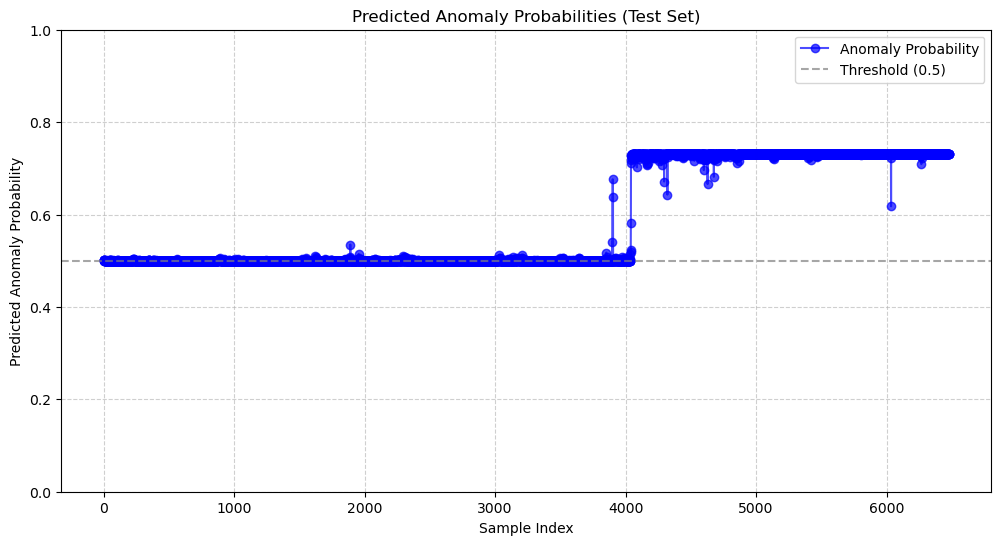

In [23]:
import matplotlib.pyplot as plt

def plot_anomaly_probabilities(predictions):
    # ✅ 예측 확률만 추출 (Anomaly 확률)
    anomaly_probs = [prob for _, prob in predictions]

    # ✅ 시각화 (선 그래프)
    plt.figure(figsize=(12, 6))
    plt.plot(anomaly_probs, marker="o", linestyle="-", color="blue", alpha=0.7, label="Anomaly Probability")
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label="Threshold (0.5)")  # 기준선 추가
    plt.xlabel("Sample Index")
    plt.ylabel("Predicted Anomaly Probability")
    plt.title("Predicted Anomaly Probabilities (Test Set)")
    plt.ylim(0, 1)  # 확률 범위 고정 (0~1)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# ✅ 예측된 확률값을 시각화
plot_anomaly_probabilities(test_predictions)


In [24]:
import pandas as pd

# ✅ CNN 예측 확률값을 저장할 DataFrame 생성
df_cnn_predictions = pd.DataFrame({
    "Anomaly_Probability": [prob for _, prob in test_predictions]
})

# ✅ CSV 파일로 저장
df_cnn_predictions.to_csv("cnn_predictions_0410_onlyT1.csv", index=False)

print("CNN Predictions saved as 'cnn_predictions0410_onlyT1.csv'.")


CNN Predictions saved as 'cnn_predictions0410_onlyT1.csv'.


### Multimodal-inference(stacking layer)

In [42]:
cnn_predictions = pd.read_csv('cnn_predictions_0410_onlyT1.csv')

In [54]:
lstm_predictions = pd.read_csv('regression_predictions_lstm_T1.csv')

In [44]:
cnn_predictions

,Anomaly_Probability
0,0.500996
1,0.500970
2,0.500533
3,0.500124
4,0.501608
...,...
6475,0.730961
6476,0.730996
6477,0.730983
6478,0.730989


In [55]:
lstm_predictions = lstm_predictions[:6480]

In [56]:
lstm_predictions

,Regression_Output,True_Labels
0,101.89988,102.472000
1,101.47234,102.507324
2,104.70834,102.542660
3,103.51423,102.578010
4,104.43867,102.613370
...,...,...
6475,305.32983,306.336120
6476,306.49725,306.364600
6477,305.39700,306.393070
6478,305.64620,306.421540


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


df_cnn = pd.read_csv("cnn_predictions_0410_onlyT1.csv")  # CNN Anomaly 확률
df_gru = pd.read_csv("regression_predictions_lstm_T1.csv")  # GRU 회귀 예측값

# Stacking을 위한 Feature 생성 (GRU 예측값 앞 6480개만 사용)
X_meta = np.column_stack((df_gru["Regression_Output"][:6480], df_cnn["Anomaly_Probability"]))  # (GRU 예측값, CNN 확률)
y_meta = np.array([1 if i >= 4961 else 0 for i in range(6480)])  # Ground Truth 생성 (6480개)

#PyTorch Tensor 변환
X_meta_tensor = torch.tensor(X_meta, dtype=torch.float32)
y_meta_tensor = torch.tensor(y_meta, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1) 형태로 변환

# === MLP 모델 정의 ===
class MLPStacking(nn.Module):
    def __init__(self, input_dim):
        super(MLPStacking, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_meta.shape[1]  # Feature 개수 (2개: GRU + CNN)
mlp_model = MLPStacking(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


X_meta_tensor, y_meta_tensor = X_meta_tensor.to(device), y_meta_tensor.to(device)


num_epochs = 20000
for epoch in range(num_epochs):
    mlp_model.train()
    optimizer.zero_grad()
    
    outputs = mlp_model(X_meta_tensor)
    loss = criterion(outputs, y_meta_tensor)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


mlp_model.eval()
with torch.no_grad():
    final_predictions = (mlp_model(X_meta_tensor) > 0.5).cpu().numpy().astype(int)

final_accuracy = accuracy_score(y_meta, final_predictions)
print(f"Final Stacked Model Accuracy (MLP): {final_accuracy:.4f}")


Epoch [10/20000], Loss: 1.6559
Epoch [20/20000], Loss: 0.6142
Epoch [30/20000], Loss: 0.6725
Epoch [40/20000], Loss: 0.6368
Epoch [50/20000], Loss: 0.6366
Epoch [60/20000], Loss: 0.6194
Epoch [70/20000], Loss: 0.6118
Epoch [80/20000], Loss: 0.6120
Epoch [90/20000], Loss: 0.6109
Epoch [100/20000], Loss: 0.6101
Epoch [110/20000], Loss: 0.6095
Epoch [120/20000], Loss: 0.6088
Epoch [130/20000], Loss: 0.6082
Epoch [140/20000], Loss: 0.6075
Epoch [150/20000], Loss: 0.6068
Epoch [160/20000], Loss: 0.6061
Epoch [170/20000], Loss: 0.6054
Epoch [180/20000], Loss: 0.6046
Epoch [190/20000], Loss: 0.6039
Epoch [200/20000], Loss: 0.6031
Epoch [210/20000], Loss: 0.6023
Epoch [220/20000], Loss: 0.6015
Epoch [230/20000], Loss: 0.6007
Epoch [240/20000], Loss: 0.5998
Epoch [250/20000], Loss: 0.5990
Epoch [260/20000], Loss: 0.5981
Epoch [270/20000], Loss: 0.5972
Epoch [280/20000], Loss: 0.5964
Epoch [290/20000], Loss: 0.5955
Epoch [300/20000], Loss: 0.5946
Epoch [310/20000], Loss: 0.5937
Epoch [320/20000]

In [52]:
# 전체 모델 저장 (추천)
torch.save(mlp_model.state_dict(), "model_weights/mlp_stacking_model.pth")


In [53]:
# 동일한 모델 구조 먼저 정의
mlp_model = MLPStacking(input_dim=input_dim).to(device)

# 저장된 파라미터 로드
mlp_model.load_state_dict(torch.load("model_weights/mlp_stacking_model.pth", map_location=device))

# 추론 모드로 전환
mlp_model.eval()


MLPStacking(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [58]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# === T5 TEST용 CSV 불러오기 ===
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === Feature 생성 (CNN 확률 + GRU 회귀 예측값)
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))

# === Ground Truth 라벨 생성 (예시: T5에서 4961 이후는 이상이라고 가정)
y_test = np.array([1 if i >= 4961 else 0 for i in range(len(X_test))])

# === Tensor로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# === MLP 모델 평가
mlp_model.eval()
with torch.no_grad():
    y_pred_prob = mlp_model(X_test_tensor).cpu().numpy()
    y_pred_cls = (y_pred_prob > 0.5).astype(int)

# === 지표 출력
print("✅ Test 성능 평가")
print(f"Accuracy : {accuracy_score(y_test, y_pred_cls):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_cls):.4f}")
print(f"AUROC    : {roc_auc_score(y_test, y_pred_prob):.4f}")


✅ Test 성능 평가
Accuracy : 0.9847
F1 Score : 0.9675
AUROC    : 0.9941


### RUL 예측

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

# === ✅ 데이터 불러오기 ===
df_cnn = pd.read_csv("cnn_predictions_0410_onlyT1.csv")  # CNN Anomaly 확률
df_gru = pd.read_csv("regression_predictions_lstm_T1.csv")  # GRU 회귀 예측값

# === ✅ Feature 구성 ===
X_meta = np.column_stack((df_gru["Regression_Output"][:6480], df_cnn["Anomaly_Probability"]))

# === ✅ RUL 라벨 생성 ===
y_rul = np.array([max(0, (4960 - i) * 0.1) for i in range(6480)])  # 초 단위 RUL (0.1초 간격)

# === ✅ Tensor 변환 ===
X_tensor = torch.tensor(X_meta, dtype=torch.float32)
y_tensor = torch.tensor(y_rul, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1)

# === ✅ RUL 예측 MLP 정의 ===
class RUL_MLP(nn.Module):
    def __init__(self, input_dim):
        super(RUL_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)  # RUL 예측 (0~648 초 범위)

# === ✅ 설정 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_meta.shape[1]
model = RUL_MLP(input_dim).to(device)
criterion = nn.MSELoss()  # 회귀니까 MSE!
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

# === ✅ 학습 ===
num_epochs = 20000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    preds = model(X_tensor)
    loss = criterion(preds, y_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f"[{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

# === ✅ 예측 및 출력 ===
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).cpu().numpy().flatten()

# === ✅ 예시 출력 (앞 10개만) ===
for i, p in enumerate(predictions[:10]):
    print(f"🧠 샘플 {i+1}: ⏳ 예측 잔여 수명: {p:.1f} 초")


[500/20000] Loss: 41375.6758
[1000/20000] Loss: 41169.0000
[1500/20000] Loss: 40179.6992
[2000/20000] Loss: 21015.4941
[2500/20000] Loss: 5337.1968
[3000/20000] Loss: 3996.2297
[3500/20000] Loss: 3188.2737
[4000/20000] Loss: 2582.5476
[4500/20000] Loss: 2104.4236
[5000/20000] Loss: 1722.3550
[5500/20000] Loss: 1422.4694
[6000/20000] Loss: 1200.1493
[6500/20000] Loss: 1051.1766
[7000/20000] Loss: 966.8217
[7500/20000] Loss: 952.9590
[8000/20000] Loss: 924.9400
[8500/20000] Loss: 919.4755
[9000/20000] Loss: 931.7387
[9500/20000] Loss: 911.3087
[10000/20000] Loss: 912.0798
[10500/20000] Loss: 933.5007
[11000/20000] Loss: 914.0877
[11500/20000] Loss: 911.0427
[12000/20000] Loss: 917.1432
[12500/20000] Loss: 920.8655
[13000/20000] Loss: 910.8142
[13500/20000] Loss: 911.1039
[14000/20000] Loss: 915.9526
[14500/20000] Loss: 913.6674
[15000/20000] Loss: 941.1426
[15500/20000] Loss: 911.2843
[16000/20000] Loss: 910.5099
[16500/20000] Loss: 910.5127
[17000/20000] Loss: 910.4879
[17500/20000] Los

In [64]:
# 저장이 안 됐다면, T1 학습 시 아래처럼 저장했어야 해:
torch.save(model.state_dict(), "rul_mlp_model.pth")


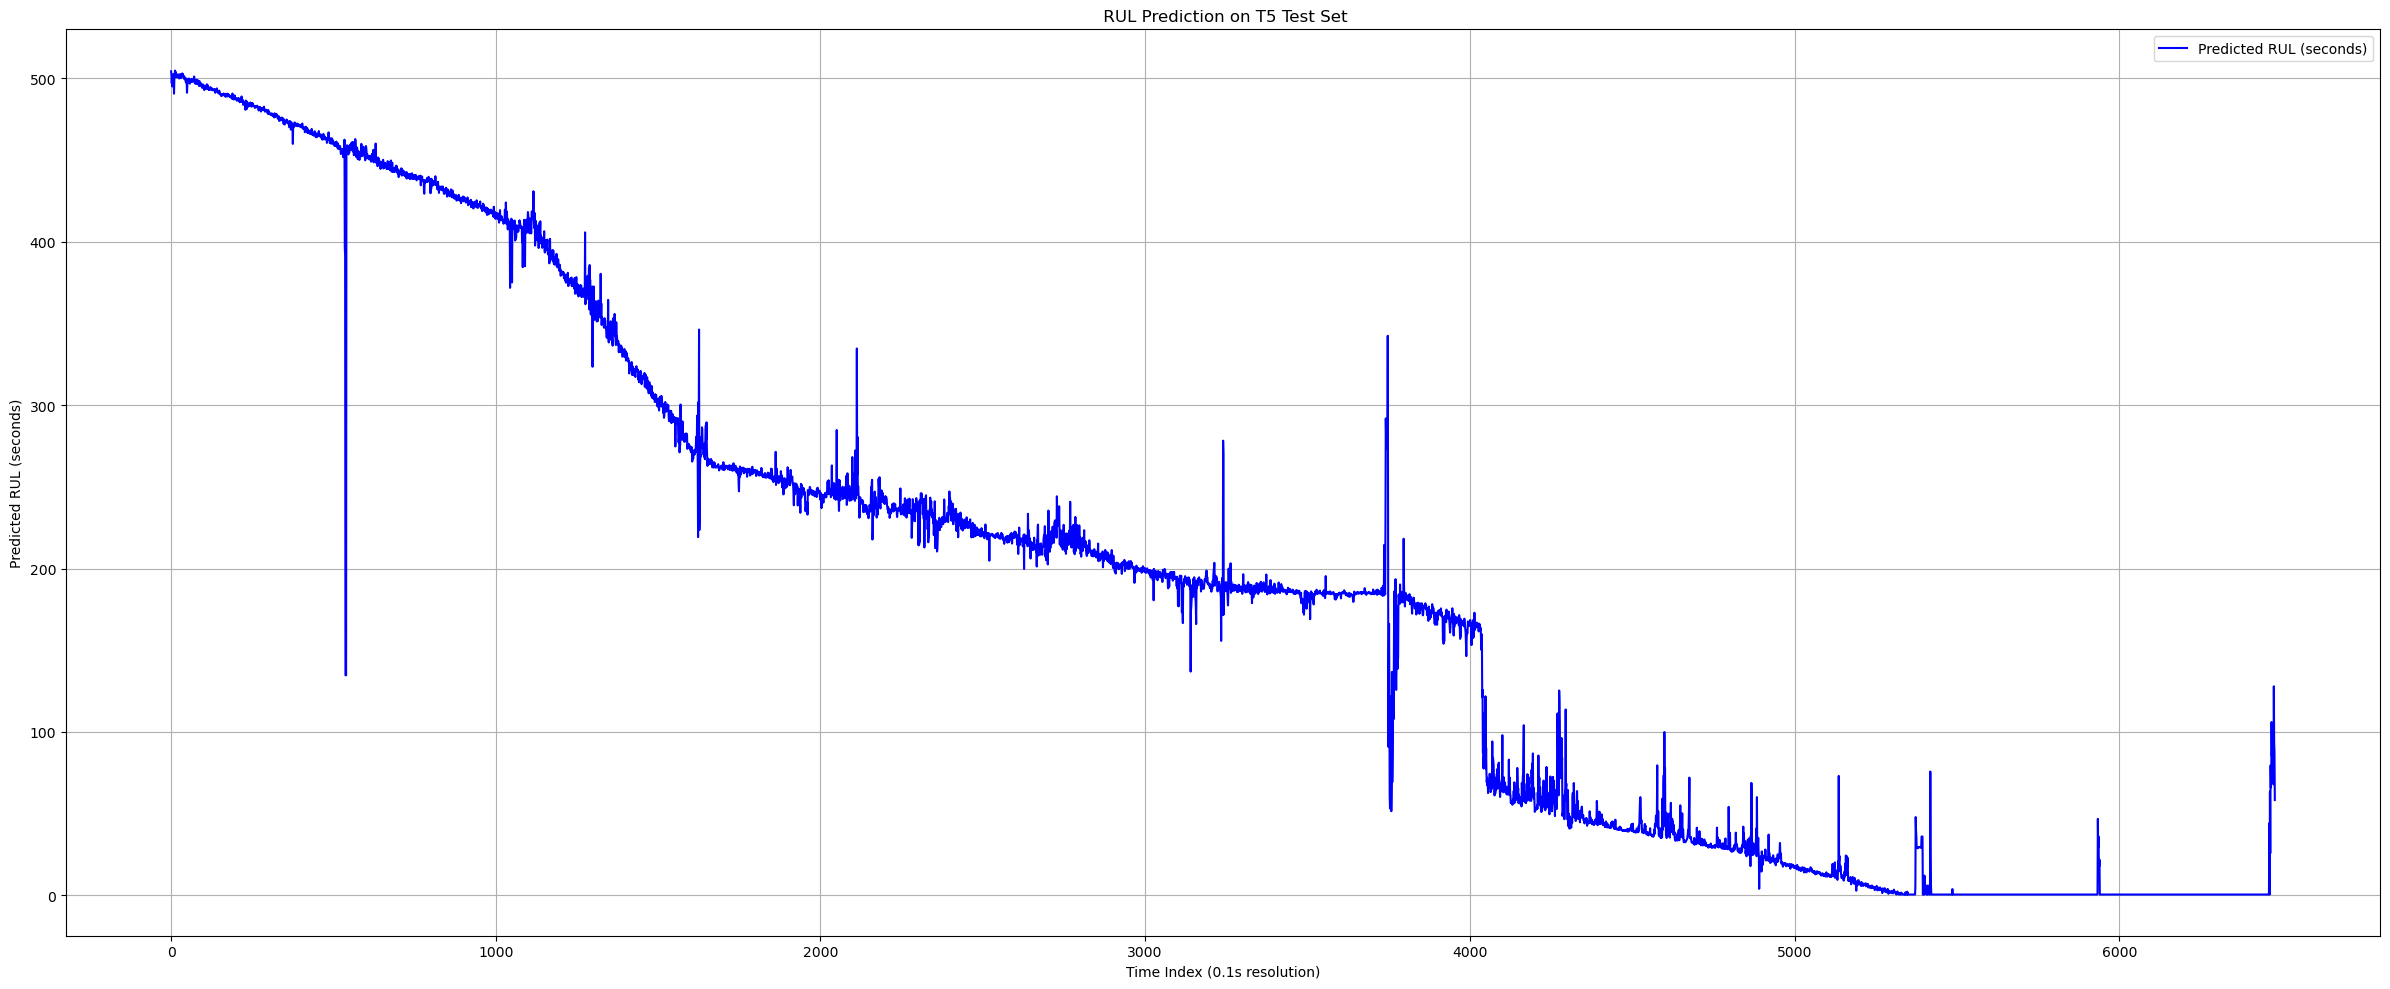


🔍 샘플별 예측 RUL (앞 20개):
Sample 1: ⏳ Predicted RUL = 504.4 seconds
Sample 2: ⏳ Predicted RUL = 502.1 seconds
Sample 3: ⏳ Predicted RUL = 497.1 seconds
Sample 4: ⏳ Predicted RUL = 500.0 seconds
Sample 5: ⏳ Predicted RUL = 495.1 seconds
Sample 6: ⏳ Predicted RUL = 499.5 seconds
Sample 7: ⏳ Predicted RUL = 500.1 seconds
Sample 8: ⏳ Predicted RUL = 502.7 seconds
Sample 9: ⏳ Predicted RUL = 502.6 seconds
Sample 10: ⏳ Predicted RUL = 490.7 seconds
Sample 11: ⏳ Predicted RUL = 499.2 seconds
Sample 12: ⏳ Predicted RUL = 500.6 seconds
Sample 13: ⏳ Predicted RUL = 504.8 seconds
Sample 14: ⏳ Predicted RUL = 503.6 seconds
Sample 15: ⏳ Predicted RUL = 503.0 seconds
Sample 16: ⏳ Predicted RUL = 503.8 seconds
Sample 17: ⏳ Predicted RUL = 502.4 seconds
Sample 18: ⏳ Predicted RUL = 500.8 seconds
Sample 19: ⏳ Predicted RUL = 500.6 seconds
Sample 20: ⏳ Predicted RUL = 502.2 seconds


In [67]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

# === ✅ T5 TEST 데이터 불러오기 ===
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === ✅ Feature 구성 ===
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))

# === ✅ Tensor 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# === ✅ 학습된 모델 불러오기
model = RUL_MLP(input_dim=2).to(device)
model.load_state_dict(torch.load("rul_mlp_model.pth"))
model.eval()

# === ✅ 예측
with torch.no_grad():
    rul_predictions = model(X_test_tensor).cpu().numpy().flatten()

# === ✅ 시각화
plt.figure(figsize=(24, 10))
plt.plot(rul_predictions, label='Predicted RUL (seconds)', color='blue')
plt.xlabel('Time Index (0.1s resolution)')
plt.ylabel('Predicted RUL (seconds)')
plt.title(' RUL Prediction on T5 Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === ✅ 예시 출력 (앞 10개만)
print("\n🔍 샘플별 예측 RUL (앞 20개):")
for i, p in enumerate(rul_predictions[:20]):
    print(f"Sample {i+1}: ⏳ Predicted RUL = {p:.1f} seconds")


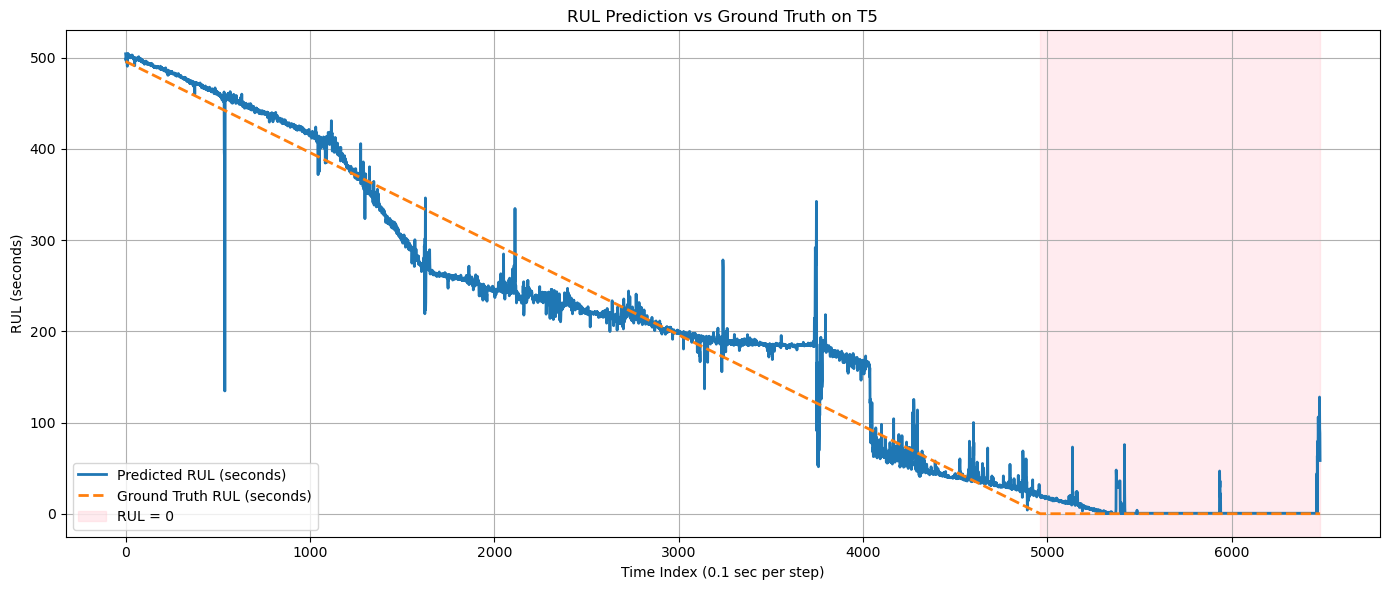

In [69]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

# === ✅ T5 TEST 데이터 불러오기
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === ✅ Feature 구성
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# === ✅ Ground Truth RUL (초 단위)
rul_gt = np.array([max(0, (4960 - i) * 0.1) for i in range(6480)])

# === ✅ 모델 정의
class RUL_MLP(nn.Module):
    def __init__(self, input_dim):
        super(RUL_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# === ✅ 모델 불러오기
model = RUL_MLP(input_dim=2).to(device)
model.load_state_dict(torch.load("rul_mlp_model.pth"))
model.eval()

# === ✅ 예측
with torch.no_grad():
    rul_pred = model(X_test_tensor).cpu().numpy().flatten()

# === ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(rul_pred, label='Predicted RUL (seconds)', linewidth=2)
plt.plot(rul_gt, label='Ground Truth RUL (seconds)', linewidth=2, linestyle='--')

# 🔴 수명 종료 이후 영역 (분홍색 음영)
plt.axvspan(4960, 6480, color='pink', alpha=0.3, label='RUL = 0 ')

plt.xlabel('Time Index (0.1 sec per step)')
plt.ylabel('RUL (seconds)')
plt.title('RUL Prediction vs Ground Truth on T5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ T5 Test Set 성능 평가
Accuracy : 0.9847
F1 Score : 0.9675
AUROC    : 0.9941


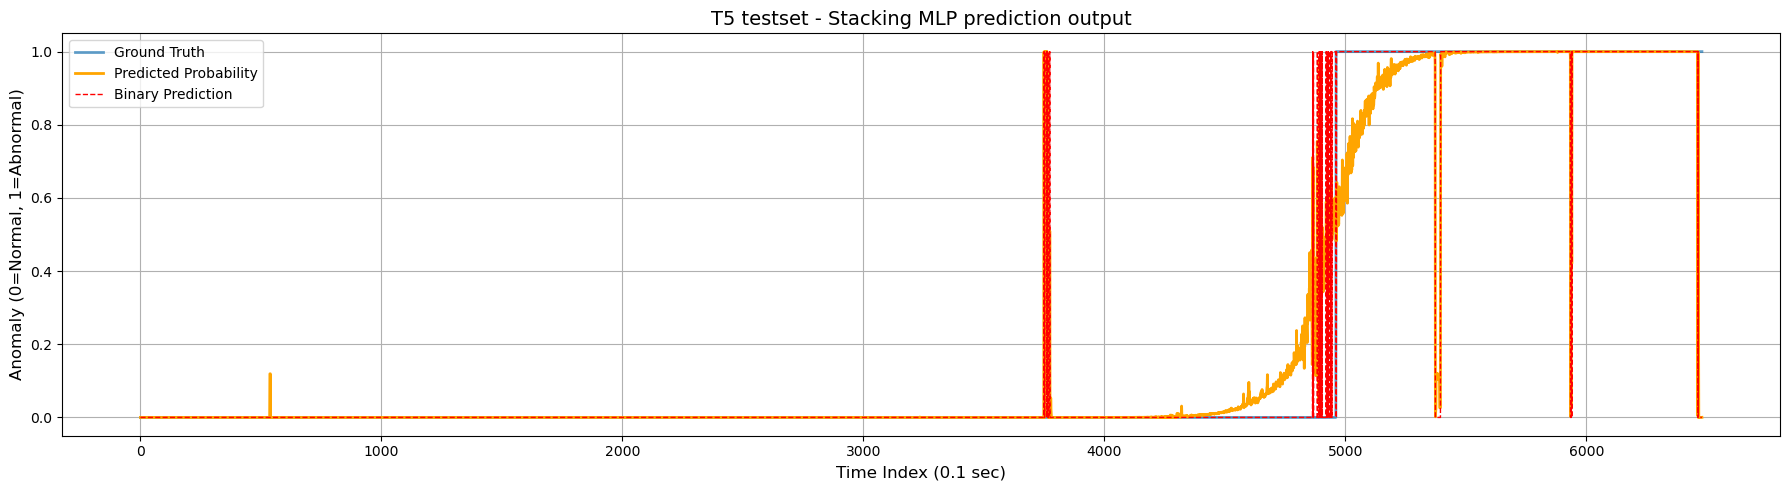

In [63]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# === ✅ T5 TEST CSV 불러오기 ===
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === ✅ Feature 생성 (GRU + CNN)
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))
y_test = np.array([1 if i >= 4961 else 0 for i in range(len(X_test))])  # Ground Truth

# === ✅ Tensor 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# === ✅ 모델 평가
mlp_model.eval()
with torch.no_grad():
    y_pred_prob = mlp_model(X_test_tensor).cpu().numpy().flatten()
    y_pred_cls = (y_pred_prob > 0.5).astype(int)

# === ✅ 성능 지표 출력
print("✅ T5 Test Set 성능 평가")
print(f"Accuracy : {accuracy_score(y_test, y_pred_cls):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_cls):.4f}")
print(f"AUROC    : {roc_auc_score(y_test, y_pred_prob):.4f}")

# === ✅ 그래프 시각화
plt.figure(figsize=(18, 5))
plt.plot(y_test, label="Ground Truth", linewidth=2, alpha=0.7)
plt.plot(y_pred_prob, label="Predicted Probability", color='orange', linewidth=2)
plt.plot(y_pred_cls, label="Binary Prediction", linestyle='--', color='red', linewidth=1)

plt.title("T5 testset - Stacking MLP prediction output", fontsize=14)
plt.xlabel("Time Index (0.1 sec)", fontsize=12)
plt.ylabel("Anomaly (0=Normal, 1=Abnormal)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### dummy

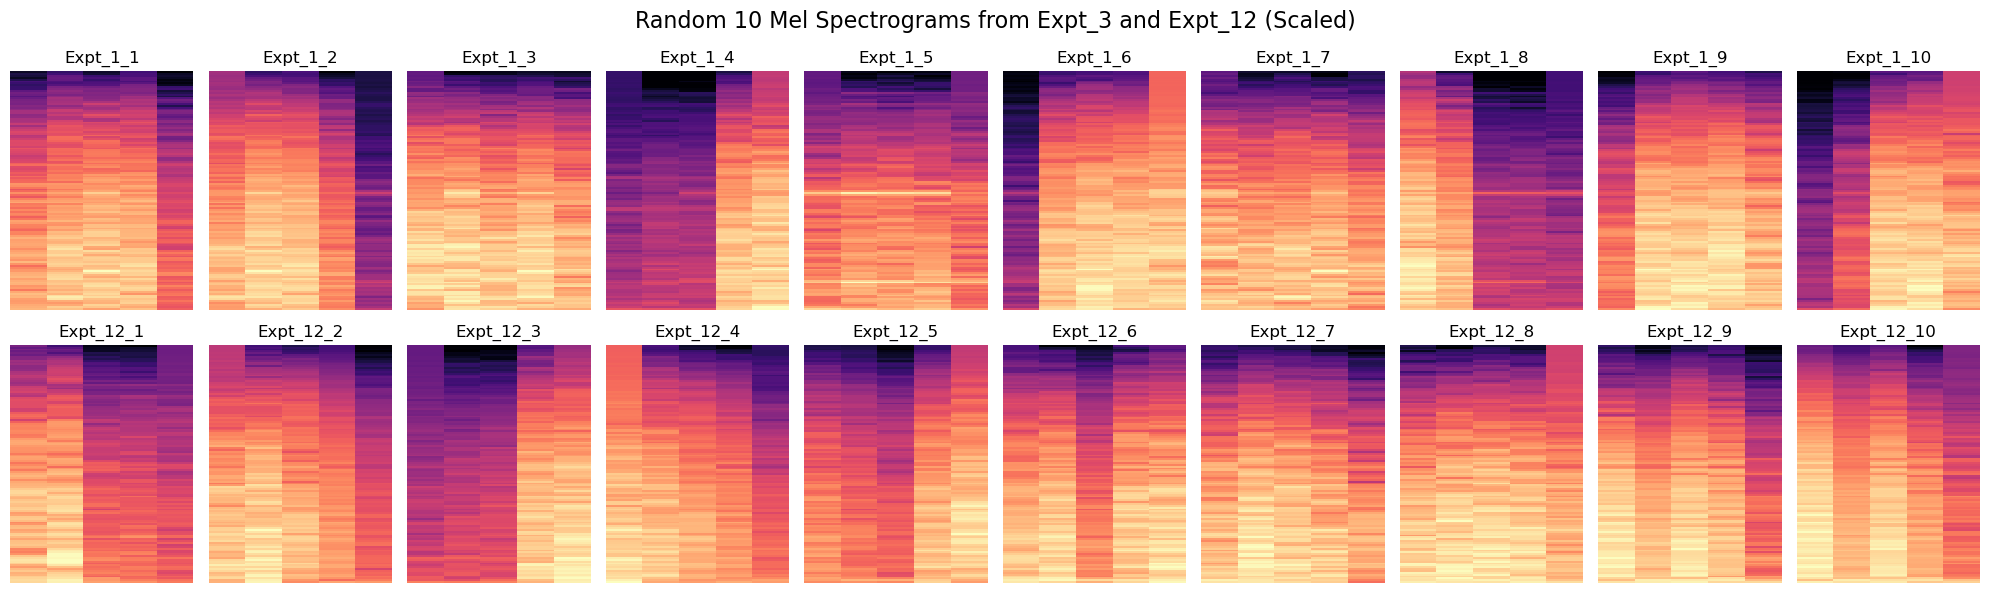

In [36]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random

# === ✅ 설정 ===
data_dir = "/home/crois-times/timeseries/projects/tool_wear_havard/data/dataverse_files/Dataset/T1/Acoustic_Emission_Data"
num_splits = 10  # 무작위로 10개만 생성하여 시각화
window_size = 1000  # STFT 윈도우 크기
desired_length = 2048  # 보간 후 신호 길이
sr = 1000  # 샘플링 레이트
n_fft = 1000  # FFT 크기
hop_length = 512  # STFT hop 크기
n_mels = 128  # Mel 필터 개수
fmax = 500  # 저주파 강조

# === ✅ Mel Spectrogram 변환 함수 ===
def generate_mel_spectrogram(signal, sr=1000, n_fft=1000, hop_length=512, n_mels=128, fmax=500):
    """Mel Spectrogram 변환 (저주파 강조)"""
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, 
                                              n_mels=n_mels, fmin=0, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.min)  # 약한 신호도 강조
    return mel_spec_db

# === ✅ Expt_3과 Expt_12에서 무작위 10개 생성 및 시각화 ===
fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for row_idx, expt_idx in enumerate([1, 12]):  # Expt_3, Expt_12 처리
    file_path = os.path.join(data_dir, f"Expt_{expt_idx}.csv")
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    # 무작위 시작점 선택 (겹치지 않도록 설정)
    start_indices = random.sample(range(0, len(df) - window_size), num_splits)
    
    for col_idx, start in enumerate(start_indices):
        # 슬라이싱
        df_split = df.iloc[start : start + window_size].reset_index(drop=True)
        
        # 신호 데이터 (첫 번째 컬럼 사용)
        signal = df_split.iloc[:, 0].values
        
        # 보간 적용 (길이 맞추기)
        x_original = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, desired_length)
        interpolator = interp1d(x_original, signal, kind='linear')
        signal_interpolated = interpolator(x_new)
        
        # === ✅ 방법 4 적용: 신호 크기 Scaling ===
        signal_scaled = signal_interpolated * np.mean(signal_interpolated)  # 크기에 비례한 Scaling
        
        # Mel Spectrogram 변환
        melspec_db = generate_mel_spectrogram(signal_scaled, sr, n_fft, hop_length, n_mels, fmax)
        
        # 시각화
        librosa.display.specshow(melspec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f"Expt_{expt_idx}_{col_idx+1}")
        axes[row_idx, col_idx].axis("off")

plt.suptitle("Random 10 Mel Spectrograms from Expt_3 and Expt_12 (Scaled)", fontsize=16)
plt.tight_layout()
plt.show()


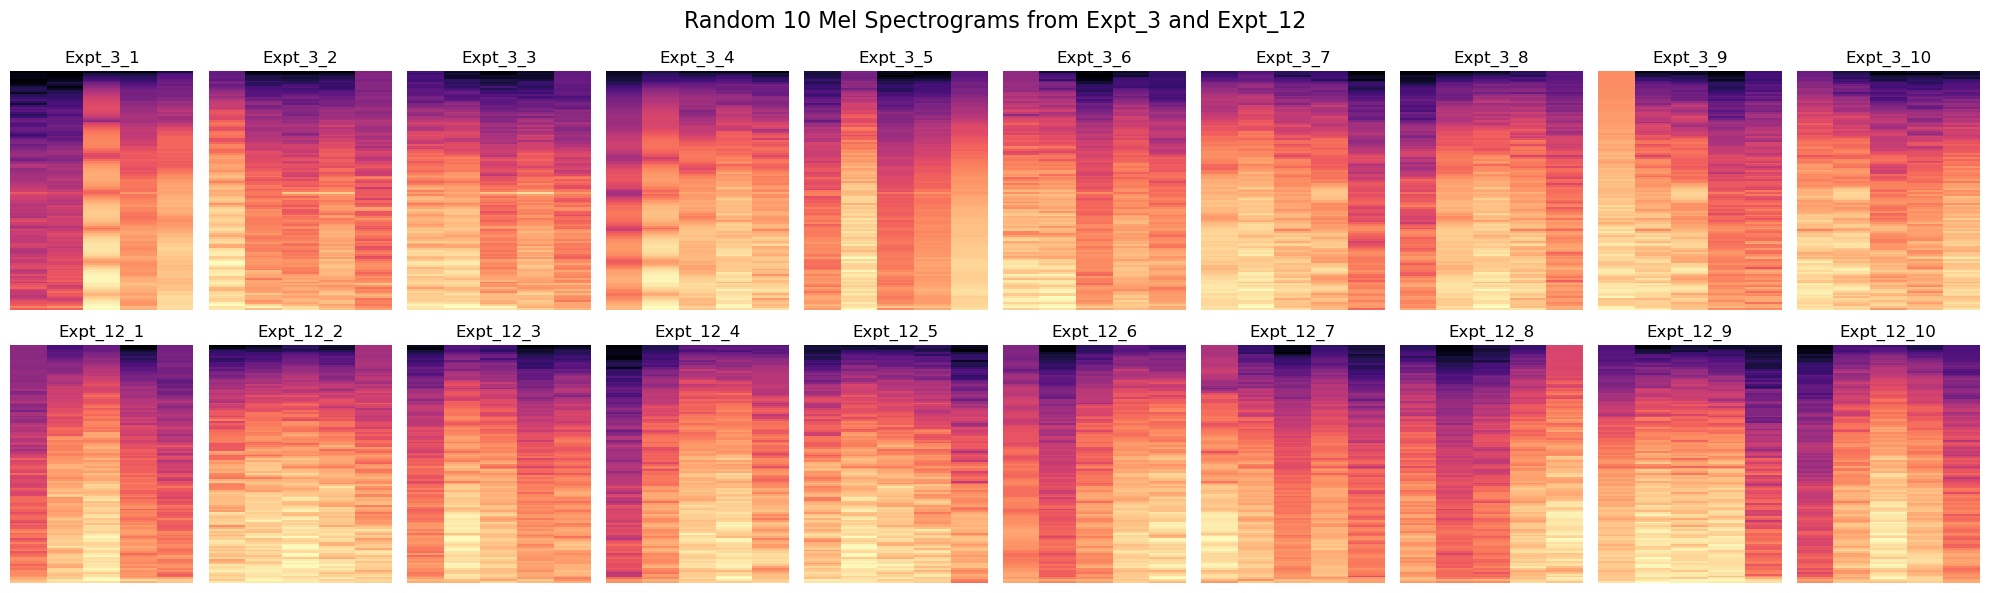

In [22]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random

# === ✅ 설정 ===
data_dir = "/home/crois-times/timeseries/projects/tool_wear_havard/data/dataverse_files/Dataset/T1/Acoustic_Emission_Data"
num_splits = 10  # 무작위로 10개만 생성하여 시각화
window_size = 1000  # STFT 윈도우 크기
desired_length = 2048  # 보간 후 신호 길이
sr = 1000  # 샘플링 레이트
n_fft = 1000  # FFT 크기
hop_length = 512  # STFT hop 크기
n_mels = 128  # Mel 필터 개수
fmax = 500  # 저주파 강조

# === ✅ Mel Spectrogram 변환 함수 ===
def generate_mel_spectrogram(signal, sr=1000, n_fft=1000, hop_length=512, n_mels=128, fmax=500):
    """Mel Spectrogram 변환 (저주파 강조)"""
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=0, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.min)  # 약한 신호도 강조
    return mel_spec_db

# === ✅ Expt_3과 Expt_12에서 무작위 10개 생성 ===
fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for row_idx, expt_idx in enumerate([3, 12]):  # Expt_3, Expt_12 처리
    file_path = os.path.join(data_dir, f"Expt_{expt_idx}.csv")
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    # 무작위 시작점 선택 (겹치지 않도록 설정)
    start_indices = random.sample(range(0, len(df) - window_size), num_splits)
    
    for col_idx, start in enumerate(start_indices):
        # 슬라이싱
        df_split = df.iloc[start : start + window_size].reset_index(drop=True)
        
        # 신호 데이터 (첫 번째 컬럼 사용)
        signal = df_split.iloc[:, 0].values
        
        # 보간 적용 (길이 맞추기)
        x_original = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, desired_length)
        interpolator = interp1d(x_original, signal, kind='linear')
        signal_interpolated = interpolator(x_new)
        
        # Mel Spectrogram 변환
        melspec_db = generate_mel_spectrogram(signal_interpolated, sr, n_fft, hop_length, n_mels, fmax)
        
        # 시각화
        librosa.display.specshow(melspec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f"Expt_{expt_idx}_{col_idx+1}")
        axes[row_idx, col_idx].axis("off")

plt.suptitle("Random 10 Mel Spectrograms from Expt_3 and Expt_12", fontsize=16)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

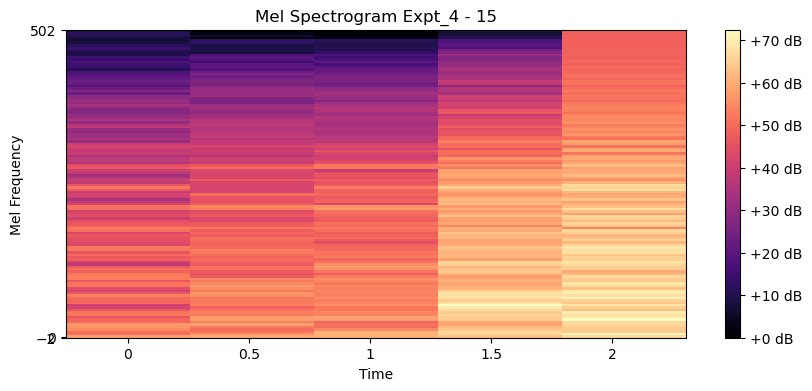

In [20]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# === ✅ 설정 ===
data_dir = "/home/crois-times/timeseries/projects/tool_wear_havard/data/dataverse_files/Dataset/T1/Acoustic_Emission_Data"
output_dir = "JJ/Harvard_Multimodal/Mel_spectrogram/T1"
num_splits = 540  # 생성할 Mel Spectrogram 개수
window_size = 1000  # STFT 윈도우 크기
desired_length = 2048  # 보간 후 신호 길이
sr = 1000  # 샘플링 레이트 (1000Hz, 동일한 조건 유지)
n_fft = 1000  # FFT 크기 (조건 유지)
hop_length = 512  # STFT hop 크기
n_mels = 128  # Mel 필터 개수
fmax = 500  # 저주파 강조 (고주파 영향 줄이기)

# 출력 폴더 생성
os.makedirs(output_dir, exist_ok=True)

# === ✅ Mel Spectrogram 변환 함수 ===
def generate_mel_spectrogram(signal, sr=1000, n_fft=1000, hop_length=512, n_mels=128, fmax=500):
    """Mel Spectrogram 변환 (저주파 강조)"""
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=0, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.min)  # 약한 신호도 강조
    return mel_spec_db

# === ✅ Expt_1~Expt_12 반복 ===
image_index = 1  # 전체 이미지 번호
for expt_idx in range(1, 13):  # Expt_1 ~ Expt_12
    file_path = os.path.join(data_dir, f"Expt_{expt_idx}.csv")
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    # Stride 계산 (겹치도록 자동 조정)
    stride = (len(df) - window_size) // (num_splits - 1)
    
    # 540개 Mel Spectrogram 생성
    for split_idx in range(num_splits):
        # 슬라이싱
        df_split = df.iloc[split_idx * stride : split_idx * stride + window_size].reset_index(drop=True)
        
        # 신호 데이터 (첫 번째 컬럼 사용)
        signal = df_split.iloc[:, 0].values
        
        # 보간 적용 (길이 맞추기)
        x_original = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, desired_length)
        interpolator = interp1d(x_original, signal, kind='linear')
        signal_interpolated = interpolator(x_new)
        
        # Mel Spectrogram 변환
        melspec_db = generate_mel_spectrogram(signal_interpolated, sr, n_fft, hop_length, n_mels, fmax)
        
        # 시각화 및 저장
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(melspec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram Expt_{expt_idx} - {split_idx+1}")
        plt.xlabel("Time")
        plt.ylabel("Mel Frequency")
        
        # 파일 저장
        file_name = f"{image_index}_Expt_{expt_idx}.png"
        save_path = os.path.join(output_dir, file_name)
        plt.savefig(save_path)
        plt.close()
        
        # 이미지 인덱스 증가
        image_index += 1

print(f"Mel Spectrogram 생성 완료. 총 {image_index-1}개 이미지 저장됨.")
